In [129]:
import pickle
from IPython.display import display, clear_output
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
import logging
from itertools import product as iterproduct, groupby, chain
import mltools
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/context_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})
logger = logging.getLogger("log")
logger.setLevel(logging.INFO)

In [126]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.pickle",
#     "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/ibislambda.model.pickle"
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [3]:
NMER = 6

In [4]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [5]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [6]:
HMM_PARAMS = pickle.load(open(args["model"], 'rb'))
HMM_PARAMS = HMM_PARAMS["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"]

In [7]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [8]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

CGCAGG CGCAGG


## Make Data

In [9]:
CONTEXT = (-10, 20)

In [10]:
all_kmers = mk_kmer_dict(NMER)
kmer_means = {kmer : float(HMM_PARAMS[HMM_PARAMS["kmer"] == kmer]["level_mean"]) for kmer in all_kmers}

In [132]:
template_events = [ev for ev in true_events if not np.isnan(ev["template.mean"])]
template_events = [ev for ev in template_events if 
               ev["ref_position"] > abs(CONTEXT[0]) and ev["ref_position"] < len(ref)-CONTEXT[1]-1]
template_events = np.array(template_events)

### Analyse

In [94]:
def dwelltime(ev):
    return ev["template.end"] - ev["template.start"]

def mean_diff(ev): 
    return ev["template.mean"] - kmer_means[ev["kmer"]]

def ev_stdv(ev):
    return ev["template.stdv"]

In [87]:
def analyse_feat(target_function, plot=True):
    values = [target_function(ev) for ev in template_events]
    if plot:
        sns.distplot(values, label=str(target_function))
        legend()
    return np.percentile(values, 1), np.percentile(values, 99)
    
    

(-2.9852576223607104, 3.3739151613802489)

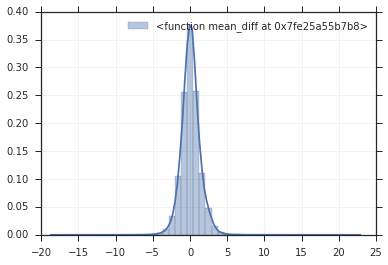

In [91]:
quantile_diff = analyse_feat(mean_diff)
quantile_diff

(14.0, 613.0)

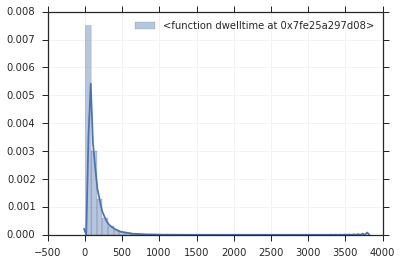

In [92]:
quantile_dwell = analyse_feat(dwelltime)
quantile_dwell

(0.40073177992794412, 2.6375458797784583)

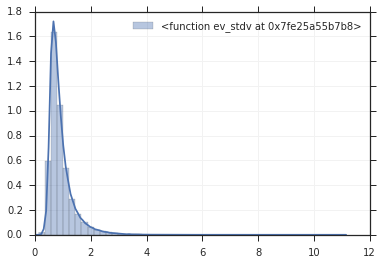

In [95]:
quantile_stdv = analyse_feat(ev_stdv)
quantile_stdv

### Filter
remove outliers

In [155]:
def filter_event_ids(event_ids, all_events):
    fevent_ids = event_ids[:]
    fevent_ids = [evid for evid in  fevent_ids
                       if quantile_diff[0] <= mean_diff(all_events[evid]) <= quantile_diff[1]]
    fevent_ids = [evid for evid in fevent_ids 
                       if quantile_dwell[0] <= dwelltime(all_events[evid]) <= quantile_dwell[1]]
    fevent_ids = [evid for evid in fevent_ids 
                       if ev_stdv(all_events[evid]) <= quantile_stdv[1]]
    logger.info("events removed: {0}".format(abs(len(fevent_ids) - len(event_ids))))
    return fevent_ids


### prepare

In [144]:
def make_target(ev): 
    return ev["template.mean"] - kmer_means[ev["kmer"]]

In [145]:
def make_features(event):
    feat = []
    feat.extend(mltools.seq2binvec(_get_context(event, *CONTEXT)))
    return feat

In [146]:
def make_data(events):     
    features = np.array([make_features(ev) for ev in events])
    target = np.array([make_target(ev) for ev in events])
    return features, target

In [147]:
features, target = make_data(template_events)

## Machine Learning

In [148]:
from sklearn import svm
from sklearn import neural_network
from sklearn.cross_validation import KFold
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics as skmetrics
from scipy import stats

In [149]:
reg = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1)
kf = KFold(len(features), n_folds=3)

In [154]:
metrics = {
    "pearson": lambda x,y: stats.pearsonr(x,y)[0],
    "mae": skmetrics.mean_absolute_error,
    "mse": skmetrics.mean_squared_error
}
metrics_result = {m: [] for m in metrics}
for test, train in kf: 
    train = filter_event_ids(train, template_events)
    f_train, f_test = features[train], features[test]
    t_train, t_test = target[train], target[test]
    reg.fit(f_train, t_train)
    t_predicted= reg.predict(f_test)
    for m, f in metrics.items(): 
        metrics_result[m].append(f(t_test, t_predicted))

{m: mean(v) for (m, v) in metrics_result.items()}

{'mae': 0.82347882421627105,
 'mse': 1.2591646093707383,
 'pearson': 0.49622361401849541}

In [ ]:
{'mae': 0.81686984540667729,
 'mse': 1.2425569735909825,
 'pearson': 0.49895286267417238}